In [1]:
; cl-waffeを読み込む
(load "../../cl-waffe.asd")
; kfttを読み込むための自作ライブラリ
(load "../../examples/kftt-data-parser.lisp")
(ql:quickload `(:clgplot :cl-waffe) :silent t)

T

T

(:CLGPLOT :CL-WAFFE)

SB-INT:SIMPLE-STYLE-WARNING: undefined function: KFTT-DATA-PARSER::REGISTER-WORD
SB-INT:SIMPLE-STYLE-WARNING: undefined function: KFTT-DATA-PARSER:CALC-DATA-SIZE
SB-INT:SIMPLE-STYLE-WARNING: undefined function: KFTT-DATA-PARSER:CALC-MAX-LENGTH


Unable to find framework CUDA


## Seq2Seqを用いてKFTTを学習

cl-waffeのRNNを用いて[京都フリー翻訳タスク (KFTT)](http://www.phontron.com/kftt/index-ja.html#leaders)を学習させる例です。

学習データのダウンロード (0.4GB程度の容量が必要です。)
```shell
$ curl -O http://www.phontron.com/kftt/download/kftt-data-1.0.tar.gz
$ tar xzvf kftt-data-1.0.tar.gz
```

In [2]:
(defpackage :seq2seq-sin
    (:use :cl :cl-waffe :cl-waffe.nn :clgplot :mgl-mat :kftt-data-parser))

(in-package :seq2seq-sin)

#<PACKAGE "SEQ2SEQ-SIN">

#<PACKAGE "SEQ2SEQ-SIN">

### Seq2Seq

Seq2Seq

問題：

### Seq2Seqモデルを定義する。

In [3]:
(defmodel Encoder (vocab-size embedding-dim hidden-size)
  :parameters ((embedding (Embedding vocab-size embedding-dim :pad-idx 0))
               (layer     (RNN embedding-dim hidden-size :num-layers 1)))
  :forward ((x)
            (with-calling-layers x
                (embedding x)
                (layer x))))

(defmodel Decoder (vocab-size embedding-dim hidden-size)
  :parameters ((embedding (Embedding vocab-size embedding-dim :pad-idx 0))
               (layer     (RNN embedding-dim hidden-size :num-layers 1))
               (h2l       (linearlayer hidden-size vocab-size)))
  :forward ((encoder-state y)
            (let* ((ye (call (self embedding) y))
                   (hs (call (self layer) ye encoder-state))
                   (h-output (call (self h2l) hs)))
                  (list h-output hs))))

(defmodel Seq2Seq (vocab-size-lang1 vocab-size-lang2 embedding-dim input-size)
  :parameters ((encoder (Encoder vocab-size-lang1 embedding-dim input-size))
               (decoder (Decoder vocab-size-lang2 embedding-dim input-size)))  
  :forward ((x y)
            (let ((x-state (call (self encoder) x))
                  (y1 (!zeros (!shape y))))
                 (setq y1 (setf (!aref y1 t) (!aref y '(1 t))))
                 (call (self decoder) x-state y1))))


NIL

NIL

NIL

SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-SIN::ENCODER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-SIN::ENCODER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-SIN::ENCODER when executing
                             SB-PCL:SPECIALIZER-TYPE-SPECIFIER for a
                             STANDARD-METHOD of a STANDARD-GENERIC-FUNCTION.
SB-INT:SIMPLE-STYLE-WARNING: undefined type: SEQ2SEQ-SIN::ENCODER
SB-INT:SIMPLE-STYLE-WARNING: Cannot find type for specializer
                             SEQ2SEQ-SIN::DECODER whe

### パラメーターの設定

In [18]:
(defparameter lang1 :ja)
(defparameter lang2 :en)

(defparameter batch-size 16)
(defparameter epoch-num 10)
(defparameter lr 1e-3)
(defparameter embedding-dim 10)
(defparameter hidden-size 20)

(defparameter sentence-maxlen 32)
; ja -> en

LANG1

LANG2

BATCH-SIZE

EPOCH-NUM

LR

EMBEDDING-DIM

HIDDEN-SIZE

SENTENCE-MAXLEN

In [19]:
(deftrainer Seq2SeqTrainer (vocab-size-lang1 vocab-size-lang2 embedding-dim hidden-size)
  :model (Seq2Seq vocab-size-lang1 vocab-size-lang2 embedding-dim hidden-size)
  :optimizer cl-waffe.optimizers:Adam
  :optimizer-args (:lr lr)
  :step-model ((x y)
               (zero-grad)
               (let* ((outs (call (self model) x y))
                      (out (softmax-cross-entropy (car outs) y)))
                     (backward out)
                     (update)
                     out))
  :predict ((x y) (call (model) x y)))

NIL

SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::COPY-SEQ2SEQTRAINER in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::SEQ2SEQTRAINER-P in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining (COMMON-LISP:SETF SEQ2SEQ-SIN::SEQ2SEQTRAINER-MODEL) in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::SEQ2SEQTRAINER-MODEL in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining (COMMON-LISP:SETF SEQ2SEQ-SIN::SEQ2SEQTRAINER-OPTIMIZER) in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::SEQ2SEQTRAINER-OPTIMIZER in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining (COMMON-LISP:SETF SEQ2SEQ-SIN::SEQ2SEQTRAINER-OPTIMIZER-REPORT) in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::SEQ2SEQTRAINER-OPTIMIZER-REPORT in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining (COMMON-LISP:SETF SEQ2SEQ-SIN::SEQ2SEQTRAINER-PREDICT) in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::SEQ2SEQTRAINER-PREDICT in DEFUN
SB-KE

### データの前処理

語彙数削減のためSentencePieceを用いる（TODO)

文字数でソートしてPaddingのコストを減らす（TODO)

In [20]:
; 辞書データを作る
(multiple-value-bind (lang1-w2i lang1-i2w) (collect-tokens :dev lang1 T)
    (defparameter w2i-lang1 lang1-w2i)
    (defparameter i2w-lang1 lang1-i2w))

(multiple-value-bind (lang2-w2i lang2-i2w) (collect-tokens :dev lang2 T)
    (defparameter w2i-lang2 lang2-w2i)
    (defparameter i2w-lang2 lang2-i2w))

;w2i: Hash Table, 単語(英語+日本語) -> Index, i2w: Index -> 単語

(format nil "Vocab_Size: ~% Lang1: ~a ~% Lang2: ~a" (hash-table-count w2i-lang1) (hash-table-count w2i-lang2))

I2W-LANG1

I2W-LANG2

"Vocab_Size: 
 Lang1: 4519 
 Lang2: 4780"

In [21]:
; 文字列操作のユーティリティ

(defun split (x str)
  (let ((pos (search x str))
        (size (length x)))
    (if pos
      (cons (subseq str 0 pos)
            (split x (subseq str (+ pos size))))
      (list str))))

(defun list-to-tensor (list)
    (const (make-mat (length list) :initial-contents list)))

(defun words-into-idx (words lang)
    "words: 単語のList, (e.g.: 臨済 宗 （ 臨濟 宗 、)... )
     lang : :ja or :en"
    
    (list-to-tensor
     (map 'list #'(lambda (word)
                          (cond
                              ((eql lang lang1)
                               (or (gethash word w2i-lang1)
                                   (gethash "<UNK>" w2i-lang1)))
                              ((eql lang lang2)
                               (or (gethash word w2i-lang1)
                                   (gethash "<UNK>" w2i-lang2)))
                              (T (error "")))) `("<BOS>" ,@words "<EOS>"))))

(defun make-train-data (language data-type)
    "Language: 言語
     data-type: :train or :test"
    
    (let ((result nil))
         (time (with-open-kftt-file line :tok data-type language
                   (push
                    (words-into-idx (split " " line) language)
                    result)))
         (reverse result)))

(defun dropout-by-sentence-len (tx ty &aux r1 r2)
    "train_X, train_Yで、sentence-maxlen以上のデータセットを削除する"
    (loop for i fixnum upfrom 0 below (length tx)
          unless (or (>= (!size (nth i tx)) sentence-maxlen)
                     (>= (!size (nth i ty)) sentence-maxlen))
          do (progn
                 (push (nth i tx) r1)
                 (push (nth i ty) r2)))
    (values (reverse r1) (reverse r2)))

SPLIT

LIST-TO-TENSOR

WORDS-INTO-IDX

MAKE-TRAIN-DATA

DROPOUT-BY-SENTENCE-LEN

SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::SPLIT in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::LIST-TO-TENSOR in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::WORDS-INTO-IDX in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::MAKE-TRAIN-DATA in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::DROPOUT-BY-SENTENCE-LEN in DEFUN


In [22]:
(defparameter train_X (make-train-data lang1 :dev))
(length train_X)

TRAIN_X

1166

Evaluation took:
  0.030 seconds of real time
  0.022552 seconds of total run time (0.021723 user, 0.000829 system)
  76.67% CPU
  70,297,336 processor cycles
  10,381,296 bytes consed
  


In [23]:
(defparameter train_Y (make-train-data lang2 :dev))

TRAIN_Y

Evaluation took:
  0.035 seconds of real time
  0.027655 seconds of total run time (0.026929 user, 0.000726 system)
  80.00% CPU
  82,515,182 processor cycles
  14,776,960 bytes consed
  


In [24]:
(multiple-value-bind (x y) (dropout-by-sentence-len train_X train_Y)
    (defparameter train_X x)
    (defparameter train_Y y))

(length train_X)

TRAIN_Y

790

In [25]:
(defparameter test_X (make-train-data lang1 :dev))
(defparameter test_Y (make-train-data lang2 :dev))

TEST_X

TEST_Y

Evaluation took:
  0.014 seconds of real time
  0.014252 seconds of total run time (0.014015 user, 0.000237 system)
  100.00% CPU
  34,087,256 processor cycles
  10,384,016 bytes consed
  
Evaluation took:
  0.030 seconds of real time
  0.021674 seconds of total run time (0.020995 user, 0.000679 system)
  73.33% CPU
  69,695,448 processor cycles
  14,779,744 bytes consed
  


In [26]:
(multiple-value-bind (x y) (dropout-by-sentence-len test_X test_Y)
    (defparameter test_X x)
    (defparameter test_Y y))

(length test_X)

TEST_Y

790

### データセットを定義する



In [27]:
(defdataset KFTT-Dataset (x y batch-size)
    :parameters ((x x)
                 (y y)
                 (batch-size batch-size))
    :next ((index)
           "Returns (list X[index:(+ index batch-size)] Y[index:(+ index batch-size)])"
           (let* ((batch-size (self batch-size))
                  (end (min (length (self x)) (+ index (self batch-size))))
                  (x (loop for i fixnum upfrom index below end
                           collect (nth i (self x))))
                  (y (loop for i fixnum upfrom index below end
                           collect (nth i (self y))))
                  (batch-maxlen (max (apply #'max (map 'list #'!size x))
                                     (apply #'max (map 'list #'!size y))))
                  (result-x (!zeros `(,(length x) ,batch-maxlen)))
                  (result-y (!zeros `(,(length y) ,batch-maxlen))))
                 
                 (dotimes (index (1- (the fixnum (length x))))
                     (setf (!aref result-x index `(0 ,(!size (nth index x)))) (nth index x))
                     (setf (!aref result-y index `(0 ,(!size (nth index y)))) (nth index y)))
                 (list result-x result-y)))
    :length (() (length (self x))))

NIL

SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::COPY-KFTT-DATASET in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::KFTT-DATASET-P in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining (COMMON-LISP:SETF SEQ2SEQ-SIN::KFTT-DATASET-X) in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::KFTT-DATASET-X in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining (COMMON-LISP:SETF SEQ2SEQ-SIN::KFTT-DATASET-Y) in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::KFTT-DATASET-Y in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining (COMMON-LISP:SETF SEQ2SEQ-SIN::KFTT-DATASET-BATCH-SIZE) in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::KFTT-DATASET-BATCH-SIZE in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining (COMMON-LISP:SETF SEQ2SEQ-SIN::KFTT-DATASET-LENGTH) in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining SEQ2SEQ-SIN::KFTT-DATASET-LENGTH in DEFUN
SB-KERNEL:REDEFINITION-WITH-DEFUN: redefining (COMMON-LISP:SETF

In [28]:
(defparameter *train-dataset* (KFTT-Dataset train_x train_y batch-size))
(defparameter *test-dataset*  (KFTT-Dataset test_x test_y batch-size))

(time (dotimes (i 100) (get-dataset *train-dataset* 0)))

*TRAIN-DATASET*

*TEST-DATASET*

NIL

Evaluation took:
  0.019 seconds of real time
  0.018471 seconds of total run time (0.018236 user, 0.000235 system)
  94.74% CPU
  45,262,096 processor cycles
  8,146,976 bytes consed
  


In [29]:
(defparameter trainer (seq2seqtrainer (hash-table-count w2i-lang1)
                                      (hash-table-count w2i-lang2)
                                      embedding-dim
                                      hidden-size))
trainer

TRAINER

<Trainer: SEQ2SEQTRAINER()>

In [33]:
(defparameter *start-time* (get-universal-time))
(defparameter losses nil)
(dotimes (epoch epoch-num)
    (format t "~ath Epoch: [~as]~%" epoch (- (get-universal-time) *start-time*))
    (let ((dataset-size 1));(get-dataset-length *train-dataset*))
          (loop for batch-num fixnum upfrom 0 below dataset-size by batch-size
                do (let* ((datum (get-dataset *train-dataset* batch-num))
                          (x (car datum))
                          (y (second datum)))
                         (push (data (step-model trainer x y)) losses)
                         (format t "Loss: ~a~%" (car (last losses)))))))
losses

*START-TIME*

LOSSES

NIL

(8.432994 8.43649 8.439802 8.442942 8.445918 8.448774 8.451493 8.454088
 8.456622 8.459015)

0th Epoch: [0s]
Loss: 8.459015
1th Epoch: [10s]
Loss: 8.459015
2th Epoch: [22s]
Loss: 8.459015
3th Epoch: [33s]
Loss: 8.459015
4th Epoch: [41s]
Loss: 8.459015
5th Epoch: [51s]
Loss: 8.459015
6th Epoch: [59s]
Loss: 8.459015
7th Epoch: [68s]
Loss: 8.459015
8th Epoch: [76s]
Loss: 8.459015
9th Epoch: [85s]
Loss: 8.459015


*IMGPATH*

NIL

NIL

0

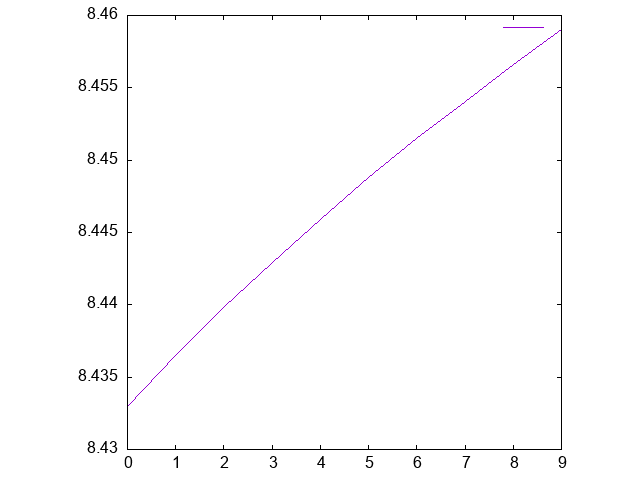

In [34]:
(defparameter *imgpath* "./tmp/Seq2Seq_KFTT_Losses.png")

(plot losses :output *imgpath*)
(jupyter:file *imgpath* :display t)
; emm